In [32]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm, shapiro, probplot

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data


In [2]:
symbols_dict = {
    'tech_symbols' : [
        "AAPL",   # Apple Inc.
        "NVDA",   # Nvidia Corporation
        "MSFT",   # Microsoft Corporation
        "GOOGL",  # Alphabet Inc. (classe A)
        "AMZN",   # Amazon.com Inc.
        "META",   # Meta Platforms Inc.
        "TSLA",   # Tesla Inc.
        "AVGO",   # Broadcom Inc.
        "TCEHY",  # Tencent Holdings Ltd.
        "TSM"     # Taiwan Semiconductor Manufacturing Company
    ],

    'commodities_symbols' : [
        "GC=F",   # Or (Gold) - utilisé pour les semi-conducteurs et connecteurs électroniques
        "SI=F",   # Argent (Silver) - utilisé dans les circuits imprimés et batteries
        "HG=F",   # Cuivre (Copper) - essentiel pour le câblage et les cartes mères
        #"AL=F",   # Aluminium (Aluminum) - utilisé dans la fabrication des boîtiers d’ordinateurs et de smartphones
        "PL=F",   # Platine (Platinum) - utilisé dans certains composants électroniques et piles à combustible
        "PA=F",   # Palladium (Palladium) - essentiel pour la fabrication de capteurs et composants électroniques
        #"LMCADS03=GB",  # Cobalt (Cobalt) - indispensable pour les batteries lithium-ion
        #"LTHM",   # Lithium (Lithium) - essentiel pour les batteries des véhicules électriques et smartphones
        #"FEF=F",  # Minerai de fer (Iron Ore) - utilisé dans la construction d’équipements et de serveurs
        #"ZNCADS03=GB"   # Zinc (Zinc) - utilisé pour le revêtement anticorrosion et certains alliages électroniques
    ],

    'telecom_symbols' : [
        "T",      # AT&T Inc.
        "VZ",     # Verizon Communications Inc.
        "TMUS",   # T-Mobile US, Inc.
        "CSCO",   # Cisco Systems, Inc.
        "NOK",    # Nokia Corporation
        #"ERIC",   # Ericsson (Telefonaktiebolaget LM Ericsson)
        "QCOM",   # Qualcomm Incorporated
        #"CHL",    # China Mobile Limited
        "NTTYY",  # Nippon Telegraph and Telephone Corporation (NTT)
        #"ORAN"    # Orange S.A.
    ]
}

all_symbols = [symbol for category in symbols_dict.values() for symbol in category]
print(all_symbols)

['AAPL', 'NVDA', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'TCEHY', 'TSM', 'GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F', 'T', 'VZ', 'TMUS', 'CSCO', 'NOK', 'QCOM', 'NTTYY']


In [ ]:
df = get_data(all_symbols, granularity='daily')

Adding Symbol: AAPL
Adding Symbol: NVDA
Adding Symbol: MSFT
Adding Symbol: GOOGL
Adding Symbol: AMZN
Adding Symbol: META
Adding Symbol: TSLA
Adding Symbol: AVGO
Adding Symbol: TCEHY
Adding Symbol: TSM
Adding Symbol: GC=F
Adding Symbol: SI=F
Adding Symbol: HG=F
Adding Symbol: PL=F
Adding Symbol: PA=F
Adding Symbol: T
Adding Symbol: VZ
Adding Symbol: TMUS
Adding Symbol: CSCO
Adding Symbol: NOK
Adding Symbol: QCOM
Adding Symbol: NTTYY


,Title,Date,Open,High,Low,Close,Adj_close,Volume
0,AAPL,2025-02-28,236.95,242.09,230.20,241.84,241.84,56796200.0
1,AAPL,2025-02-27,239.41,242.46,237.06,237.30,237.30,41153600.0
2,AAPL,2025-02-26,244.33,244.98,239.13,240.36,240.36,44433600.0
3,AAPL,2025-02-25,248.00,250.00,244.91,247.04,247.04,48013300.0
4,AAPL,2025-02-24,244.93,248.86,244.42,247.10,247.10,51326400.0


In [8]:
df.head()

,Title,Date,Open,High,Low,Close,Adj_close,Volume
0,AAPL,2025-02-28,236.95,242.09,230.20,241.84,241.84,56796200.0
1,AAPL,2025-02-27,239.41,242.46,237.06,237.30,237.30,41153600.0
2,AAPL,2025-02-26,244.33,244.98,239.13,240.36,240.36,44433600.0
3,AAPL,2025-02-25,248.00,250.00,244.91,247.04,247.04,48013300.0
4,AAPL,2025-02-24,244.93,248.86,244.42,247.10,247.10,51326400.0


In [7]:
df.columns

Index(['Title', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume'], dtype='object')

The Augmented Dickey-Fuller (ADF) test results indicate that most stock price time series are **non-stationary**, as their **p-values are above 0.05**. Only **NOK (Nokia) is stationary**, with a **p-value of 0.0099**, suggesting its price series does not exhibit a unit root and has a stable statistical property over time.

In [ ]:
def test_stationarity_per_stock(data: pd.DataFrame, var: str ='Adj_close') -> pd.DataFrame:
    """
    Perform the Augmented Dickey-Fuller (ADF) test for stationarity on each stock.

    Args :
    ----------
    data : pd.DataFrame
        A DataFrame containing at least the columns ['Title', 'Date', var].
    var : str, optional
        The column name representing the time series values (default is 'Adj_close').

    Returns : 
    -------
    pd.DataFrame
        A DataFrame with the ADF statistic, p-value, and stationarity result for each stock.
    """
    results = []

    data["Date"] = pd.to_datetime(data["Date"])
    
    data = data.sort_values(by=["Title", "Date"])

    for title, group in data.groupby("Title"):
        close_prices = group[var].values
        result = adfuller(close_prices, autolag='AIC')
        p_value = result[1]

        results.append({
            "Title": title,
            "ADF Statistic": result[0],
            "p-value": p_value,
            "Stationary": p_value < 0.05  #si p < 0.05, la série est stationnaire
        })

    results_df = pd.DataFrame(results)
    return results_df

df.dropna(inplace=True)
test_stationarity_per_stock(df)


,Title,ADF Statistic,p-value,Stationary
0,AAPL,1.305374,0.996639,False
1,AMZN,0.499340,0.984853,False
2,AVGO,4.022765,1.000000,False
3,CSCO,0.156816,0.969733,False
4,GC=F,0.795798,0.991568,False
5,GOOGL,0.662318,0.989055,False
6,HG=F,-1.665505,0.448967,False
7,META,1.521696,0.997603,False
8,MSFT,1.330014,0.996772,False
9,NOK,-3.432321,0.009905,True


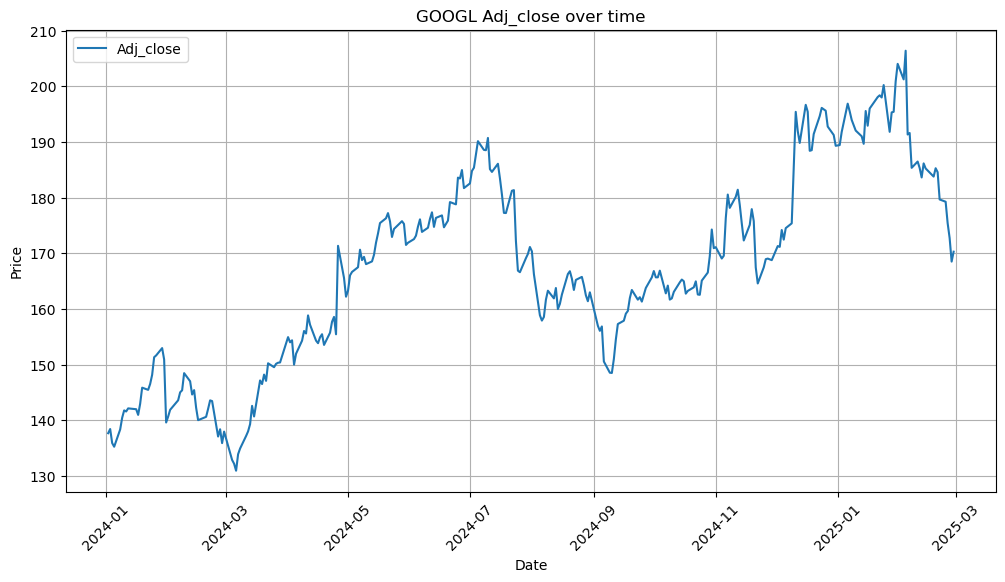

In [ ]:
def plot_stock(df: pd.DataFrame, title: str, columns: str = 'Adj_close', begin_y: int = 2024) -> None:
    """
    Plot the time series of stock prices for a given stock.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing stock data with at least 'Title' and 'Date' columns.
    title : str
        The title (name) of the stock to be plotted.
    columns : str, optional
        The column(s) to plot (default is 'Adj_close').
    begin_y : int, optional
        The starting year for filtering the data (default is 2024).

    Returns
    -------
    None
        Displays the plot.
    """
    df_test = df[df['Title'] == title].copy()
    df_test = df_test[df_test["Date"].dt.year >= begin_y]
    plt.figure(figsize=(12, 6))

    for col in columns:
        plt.plot(df_test["Date"], df_test[col], linestyle="-", label=col)
        plt.title(f"{title} {col} over time")

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

    del df_test

columns = ['Adj_close']

plot_stock(df, 'GOOGL', columns=columns)


In [12]:
for var in df.columns:
    if var in ['Date', 'Title']: continue
    df[var] = df.groupby('Title')[var].pct_change()

df.dropna(inplace=True)


In [27]:
print(df.describe())

                                Date          Open          High  \
count                          79541  79541.000000  79541.000000   
mean   2017-08-10 10:38:54.222601984     -0.000320     -0.000353   
min              2010-01-04 00:00:00     -0.282569     -0.461696   
25%              2013-10-25 00:00:00     -0.010058     -0.008442   
50%              2017-08-07 00:00:00     -0.000531      0.000000   
75%              2021-06-02 00:00:00      0.008824      0.007692   
max              2025-02-27 00:00:00      0.464615      0.770344   
std                              NaN      0.021122      0.019308   

                Low         Close     Adj_close        Volume  
count  79541.000000  79541.000000  79541.000000  79541.000000  
mean      -0.000341     -0.000320     -0.000382      0.451754  
min       -0.293292     -0.293292     -0.293292     -0.999997  
25%       -0.009381     -0.009877     -0.009889     -0.212121  
50%       -0.000965     -0.000434     -0.000471      0.015424  
75%

In [ ]:
df['Adj_close'] = df['Adj_close'] / 100  

ADF test for AAPL: p-value=0.0000
ADF test for AMZN: p-value=0.0000
ADF test for AVGO: p-value=0.0000
ADF test for CSCO: p-value=0.0000
ADF test for GC=F: p-value=0.0000
ADF test for GOOGL: p-value=0.0000
ADF test for HG=F: p-value=0.0000
ADF test for META: p-value=0.0000
ADF test for MSFT: p-value=0.0000
ADF test for NOK: p-value=0.0000
ADF test for NTTYY: p-value=0.0000
ADF test for NVDA: p-value=0.0000
ADF test for PA=F: p-value=0.0000
ADF test for PL=F: p-value=0.0000
ADF test for QCOM: p-value=0.0000
ADF test for SI=F: p-value=0.0000
ADF test for T: p-value=0.0000
ADF test for TCEHY: p-value=0.0000
ADF test for TMUS: p-value=0.0000
ADF test for TSLA: p-value=0.0000
ADF test for TSM: p-value=0.0000
ADF test for VZ: p-value=0.0000


In [13]:
test_stationarity_per_stock(df)

,Title,ADF Statistic,p-value,Stationary
0,AAPL,-20.319347,0.000000e+00,True
1,AMZN,-62.836236,0.000000e+00,True
2,AVGO,-23.732600,0.000000e+00,True
3,CSCO,-22.519931,0.000000e+00,True
4,GC=F,-63.362580,0.000000e+00,True
5,GOOGL,-20.784154,0.000000e+00,True
6,HG=F,-23.328376,0.000000e+00,True
7,META,-19.011371,0.000000e+00,True
8,MSFT,-21.730975,0.000000e+00,True
9,NOK,-27.674538,0.000000e+00,True


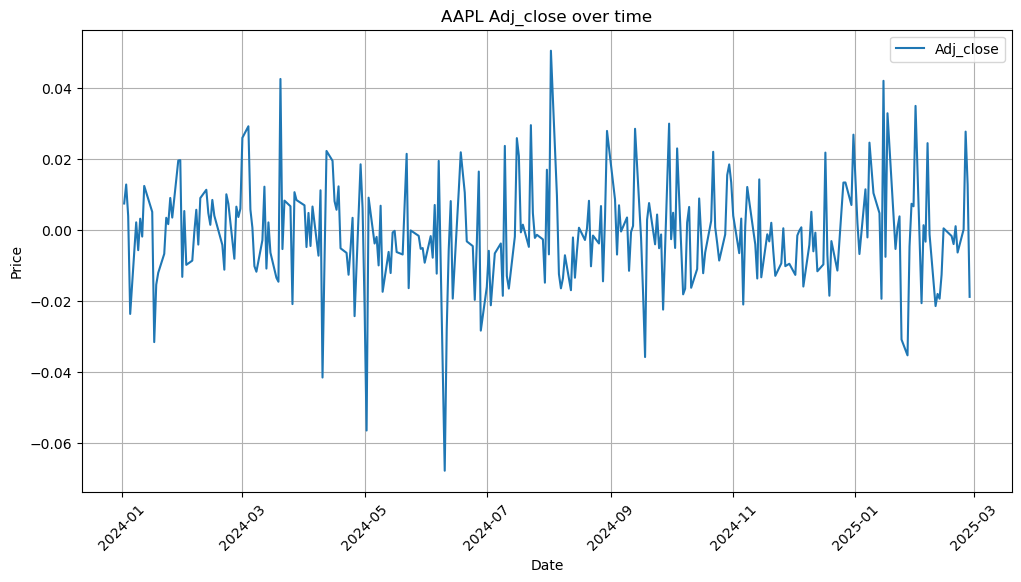

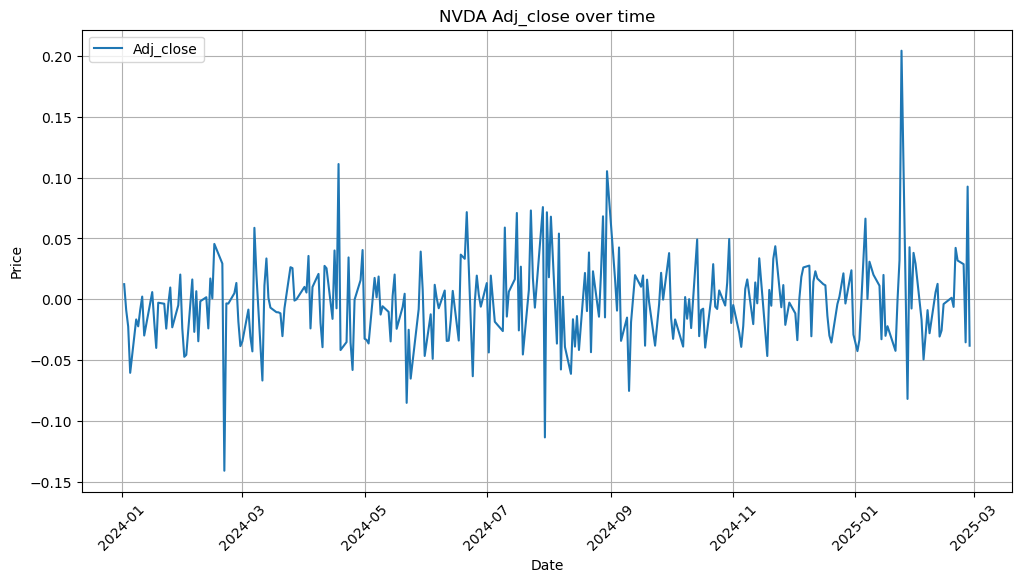

In [14]:
for symbol in all_symbols[:2]:
    plot_stock(df, symbol, columns=columns)

c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

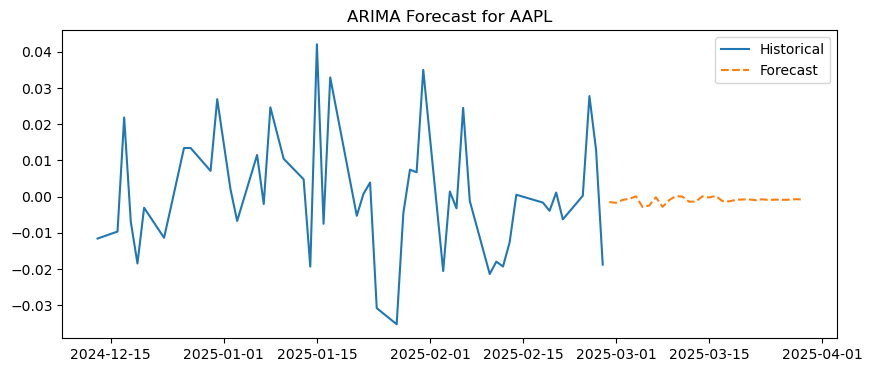

c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

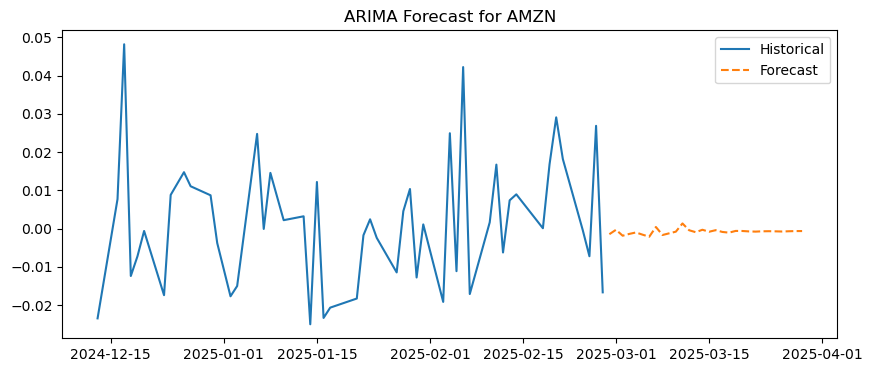

c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

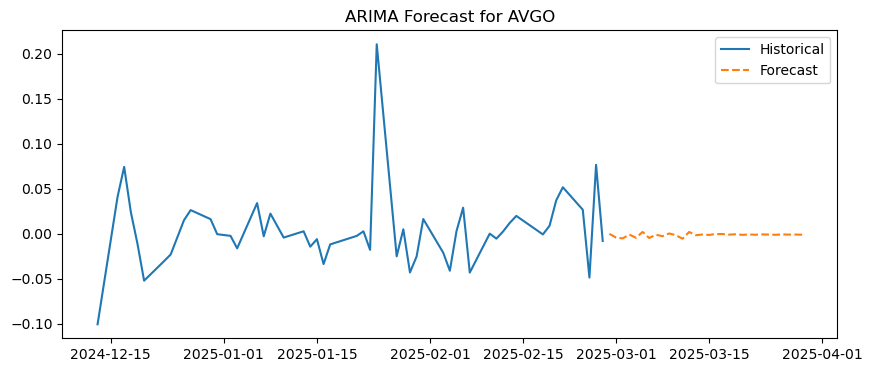

            AAPL  AMZN  AVGO
2025-02-28   NaN   NaN   NaN
2025-03-01   NaN   NaN   NaN
2025-03-02   NaN   NaN   NaN
2025-03-03   NaN   NaN   NaN
2025-03-04   NaN   NaN   NaN
2025-03-05   NaN   NaN   NaN
2025-03-06   NaN   NaN   NaN
2025-03-07   NaN   NaN   NaN
2025-03-08   NaN   NaN   NaN
2025-03-09   NaN   NaN   NaN
2025-03-10   NaN   NaN   NaN
2025-03-11   NaN   NaN   NaN
2025-03-12   NaN   NaN   NaN
2025-03-13   NaN   NaN   NaN
2025-03-14   NaN   NaN   NaN
2025-03-15   NaN   NaN   NaN
2025-03-16   NaN   NaN   NaN
2025-03-17   NaN   NaN   NaN
2025-03-18   NaN   NaN   NaN
2025-03-19   NaN   NaN   NaN
2025-03-20   NaN   NaN   NaN
2025-03-21   NaN   NaN   NaN
2025-03-22   NaN   NaN   NaN
2025-03-23   NaN   NaN   NaN
2025-03-24   NaN   NaN   NaN
2025-03-25   NaN   NaN   NaN
2025-03-26   NaN   NaN   NaN
2025-03-27   NaN   NaN   NaN
2025-03-28   NaN   NaN   NaN
2025-03-29   NaN   NaN   NaN


In [ ]:
from typing import Dict
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

def forecast_stock_prices(df: pd.DataFrame, num_stocks: int = 3, steps: int = 30) -> pd.DataFrame:
    """
    Forecast stock prices using an ARIMA model and plot the results.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing stock data with 'Title', 'Date', and 'Adj_close' columns.
    num_stocks : int, optional
        Number of stocks to forecast (default is 3).
    steps : int, optional
        Number of future time steps to forecast (default is 30).

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the forecasted values for each stock.
    """
    # Sort the DataFrame to ensure time series order
    df.sort_values(by=['Title', 'Date'], inplace=True)

    forecast_results: Dict[str, pd.Series] = {}

    # Loop over unique stock titles (limited to `num_stocks`)
    for title in df['Title'].unique()[:num_stocks]:
        df_title = df[df['Title'] == title].set_index('Date')
        series = df_title['Adj_close'].dropna()

        if len(series) < 22:  # Ensure sufficient data points for ARIMA(20,0,2)
            print(f"Skipping {title}: Not enough data points.")
            continue

        # Fit ARIMA model
        model = sm.tsa.ARIMA(series, order=(20, 0, 2))
        model_fit = model.fit()

        # Forecast the next `steps` days
        forecast = model_fit.forecast(steps=steps)

        # Generate forecast index with inferred frequency
        freq = pd.infer_freq(series.index)
        forecast_index = pd.date_range(start=series.index[-1], periods=steps + 1, freq=freq)[1:]

        # Store forecast results
        forecast_results[title] = pd.Series(forecast, index=forecast_index)

        # Plot the forecast
        plt.figure(figsize=(10, 4))
        plt.plot(series[-50:], label='Historical')
        plt.plot(forecast_index, forecast, label='Forecast', linestyle='dashed')
        plt.title(f"ARIMA Forecast for {title}")
        plt.legend()
        plt.show()

    # Convert forecast results to DataFrame
    forecast_df = pd.DataFrame(forecast_results)
    return forecast_df, forecast_index

# Example usage:
forecast_df, forecast_index = forecast_stock_prices(df, 1)
# print(forecast_df)


In [27]:
forecast_index

DatetimeIndex(['2025-03-02', '2025-03-09', '2025-03-16', '2025-03-23',
               '2025-03-30', '2025-04-06', '2025-04-13', '2025-04-20',
               '2025-04-27', '2025-05-04', '2025-05-11', '2025-05-18',
               '2025-05-25', '2025-06-01', '2025-06-08', '2025-06-15',
               '2025-06-22', '2025-06-29', '2025-07-06', '2025-07-13',
               '2025-07-20', '2025-07-27', '2025-08-03', '2025-08-10',
               '2025-08-17', '2025-08-24', '2025-08-31', '2025-09-07',
               '2025-09-14', '2025-09-21'],
              dtype='datetime64[ns]', freq='W-SUN')

In [ ]:
# Fit AutoARIMA on stock data (example for one stock)
def get_best_arima(series):
    model = pm.auto_arima(series, 
                          start_p=0, max_p=20, 
                          start_q=0, max_q=5,
                          seasonal=False, 
                          stepwise=True, 
                          trace=False,  # Show iteration logs
                          suppress_warnings=True, 
                          information_criterion='aic')  # Minimize AIC
    return model


In [24]:
def get_best_arima_per_stock(df: pd.DataFrame) -> Dict[str, pm.arima.ARIMA]:
    """
    Finds the best ARIMA model for each stock in the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing stock data with at least 'Title', 'Date', and 'Adj_close' columns.

    Returns
    -------
    Dict[str, pm.arima.ARIMA]
        A dictionary where the keys are stock titles, and values are the best ARIMA models.
    """
    best_models = {}

    # Sort values to ensure correct time series order
    df = df.sort_values(by=['Title', 'Date']).copy()

    for title in df['Title'].unique():
        stock_data = df[df['Title'] == title].set_index('Date')
        series = stock_data['Adj_close'].dropna()  # Drop missing values

        if len(series) < 30:  # Ensure enough data points
            print(f"Skipping {title}: Not enough data points for ARIMA.")
            continue

        try:
            # Call the existing function to find the best ARIMA model
            model = get_best_arima(series)
            
            best_models[title] = model
            print(f"Best ARIMA for {title}: {model.order} (AIC={model.aic():.2f}, BIC={model.bic():.2f})")

        except Exception as e:
            print(f"Error for {title}: {e}")

    return best_models

# Example usage
best_arima_models = get_best_arima_per_stock(df)


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-19976.049, Time=0.74 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-19978.503, Time=0.52 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-19978.445, Time=1.25 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-19976.675, Time=0.68 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-19977.261, Time=1.41 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-19974.654, Time=1.94 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-19984.875, Time=1.36 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-19981.855, Time=1.27 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-19982.953, Time=1.66 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-19983.405, Time=3.14 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-19984.832, Time=0.79 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-19980.924, Time=2.72 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 17.499 seconds
Error for AAPL: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-18804.174, Time=0.58 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-18803.260, Time=0.36 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-18803.276, Time=0.48 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-18801.910, Time=0.57 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-18806.552, Time=1.61 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-18805.793, Time=1.21 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-18805.813, Time=2.07 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-18804.960, Time=3.34 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 10.237 seconds
Error for AMZN: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-17808.413, Time=0.77 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-17820.166, Time=0.56 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-17819.209, Time=1.56 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-17823.662, Time=2.05 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-17826.601, Time=4.44 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-17832.612, Time=2.99 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-17830.620, Time=3.42 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-17830.624, Time=3.13 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-17824.930, Time=1.90 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-17828.627, Time=2.17 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-17839.959, Time=6.51 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-17833.102, Time=3.34 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-17838.020, Time=5.48 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-17838.004, Time=5.05 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-17831.504, Time=5.73 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-17836.051, Time=4.73 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 53.891 seconds
Error for AVGO: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-20480.489, Time=0.63 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-20490.566, Time=0.77 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-20490.262, Time=2.16 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-20489.059, Time=1.71 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-20488.905, Time=1.23 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-20486.974, Time=2.50 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-20489.354, Time=2.49 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 11.512 seconds
Error for CSCO: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-23961.652, Time=1.25 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-23963.210, Time=1.16 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-23963.246, Time=1.11 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-23961.276, Time=1.53 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-23961.308, Time=1.59 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-23959.889, Time=1.83 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-23962.790, Time=2.85 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 11.356 seconds
Error for GC=F: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-20152.499, Time=0.92 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-20154.577, Time=0.46 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-20154.542, Time=1.04 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-20152.642, Time=1.52 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-20152.805, Time=1.69 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-20150.631, Time=3.78 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-20155.725, Time=1.89 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-20153.447, Time=1.51 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-20153.766, Time=1.16 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-20153.898, Time=3.62 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-20155.696, Time=2.23 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-20151.751, Time=6.52 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 26.357 seconds
Error for GOOGL: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21569.126, Time=0.97 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-21569.465, Time=0.87 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-21569.482, Time=1.35 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-21567.508, Time=2.07 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-21567.519, Time=1.66 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-21565.512, Time=3.89 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-21567.492, Time=3.32 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 14.150 seconds
Error for HG=F: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14511.234, Time=0.72 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-14509.987, Time=0.62 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-14509.909, Time=0.70 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-14507.254, Time=1.09 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-14510.905, Time=1.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 4.223 seconds
Error for META: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-20633.369, Time=0.69 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-20669.561, Time=0.33 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-20669.612, Time=0.91 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-20667.673, Time=2.59 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-20667.665, Time=0.52 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-20665.676, Time=0.74 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-20674.502, Time=1.85 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-20636.883, Time=1.41 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-20672.516, Time=2.88 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-20672.513, Time=4.77 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-20674.304, Time=1.48 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-20670.517, Time=2.83 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 21.020 seconds
Error for MSFT: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-16680.117, Time=0.67 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-16687.668, Time=0.48 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-16687.076, Time=1.00 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-16689.682, Time=1.28 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-16688.503, Time=1.80 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-16686.355, Time=3.08 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-16688.749, Time=2.93 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-16686.579, Time=2.22 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-16689.004, Time=2.86 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 16.338 seconds
Error for NOK: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-22400.892, Time=1.07 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-22422.784, Time=1.06 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22422.535, Time=1.38 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-22420.808, Time=2.17 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-22420.808, Time=1.42 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-22418.800, Time=5.49 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-22421.371, Time=4.74 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 17.369 seconds
Error for NTTYY: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-16002.264, Time=0.71 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-16027.016, Time=0.52 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-16025.265, Time=1.25 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-16029.133, Time=1.85 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-16028.258, Time=2.07 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-16026.898, Time=2.00 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-16029.678, Time=1.22 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-16027.652, Time=2.08 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-16028.225, Time=1.64 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-16026.254, Time=5.25 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-16033.147, Time=3.19 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-16028.968, Time=3.48 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-16030.703, Time=1.18 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-16031.343, Time=10.66 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-16030.988, Time=5.01 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-16005.077, Time=1.22 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-16031.533, Time=4.22 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-16032.463, Time=1.36 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-16039.413, Time=14.40 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-16037.861, Time=9.52 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-16027.759, Time=12.93 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-16029.758, Time=9.72 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-16029.777, Time=4.94 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-16025.790, Time=15.04 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 115.500 seconds
Error for NVDA: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-8212.610, Time=0.47 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8210.634, Time=0.46 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-8210.635, Time=0.40 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8209.698, Time=0.62 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-8210.615, Time=0.68 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.645 seconds
Error for PA=F: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11582.767, Time=0.67 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-11585.090, Time=0.19 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-11585.155, Time=0.89 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11583.187, Time=1.45 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-11583.227, Time=1.54 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-11581.368, Time=1.69 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-11584.164, Time=0.67 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 7.121 seconds
Error for PL=F: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-18599.238, Time=0.70 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-18613.504, Time=1.03 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-18612.644, Time=0.65 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-18614.084, Time=1.28 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-18612.171, Time=1.99 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-18612.162, Time=1.32 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-18613.900, Time=0.74 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-18610.170, Time=1.56 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-18612.436, Time=1.53 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 10.806 seconds
Error for QCOM: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-17834.946, Time=0.91 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-17833.817, Time=0.73 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-17833.782, Time=1.02 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-17832.116, Time=1.49 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-17832.955, Time=1.57 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 5.741 seconds
Error for SI=F: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-22272.988, Time=0.89 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-22275.423, Time=1.13 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22275.252, Time=1.74 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-22274.951, Time=1.07 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-22270.879, Time=2.31 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-22272.896, Time=4.54 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-22275.202, Time=3.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 14.717 seconds
Error for T: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-17774.659, Time=0.87 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-17789.158, Time=0.60 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-17789.290, Time=1.98 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-17787.285, Time=1.67 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-17787.394, Time=3.53 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-17785.777, Time=2.61 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-17788.831, Time=2.96 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 14.232 seconds
Error for TCEHY: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-18028.608, Time=0.59 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-18049.031, Time=0.40 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-18047.262, Time=1.22 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-18054.017, Time=2.12 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-18057.329, Time=1.72 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-18055.445, Time=2.59 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-18055.264, Time=3.04 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-18047.021, Time=3.65 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-18053.450, Time=3.44 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-18057.893, Time=3.00 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-18054.389, Time=1.70 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-18055.998, Time=4.68 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-18055.832, Time=2.06 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-18047.310, Time=6.57 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-18054.009, Time=8.93 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 45.756 seconds
Error for TMUS: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14044.736, Time=0.81 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-14042.738, Time=0.35 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-14042.710, Time=2.45 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-14040.872, Time=2.64 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-14044.394, Time=1.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 7.416 seconds
Error for TSLA: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-19337.927, Time=0.66 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-19364.786, Time=0.35 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-19364.147, Time=0.56 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-19363.083, Time=1.28 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-19363.125, Time=2.18 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-19361.047, Time=4.80 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-19368.132, Time=1.07 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-19340.410, Time=2.07 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-19366.340, Time=1.21 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-19366.382, Time=2.92 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-19367.558, Time=2.46 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-19364.270, Time=6.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 25.625 seconds
Error for TSM: 'ARIMA' object has no attribute 'aic_'
Performing stepwise search to minimize aic


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-23164.017, Time=0.83 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-23166.051, Time=0.87 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-23165.885, Time=1.00 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-23165.735, Time=1.33 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-23162.785, Time=2.49 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-23161.430, Time=2.28 sec


c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-23165.513, Time=1.85 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 10.665 seconds
Error for VZ: 'ARIMA' object has no attribute 'aic_'


In [25]:
for title, model in best_arima_models.items():
    if hasattr(model, 'aic') and hasattr(model, 'bic'):  # Vérifier que le modèle a les attributs nécessaires
        print(f"Stock: {title}")
        print(f"  ARIMA Order: {model.order}")
        print(f"  AIC: {model.aic():.2f}")
        print(f"  BIC: {model.bic():.2f}")
        print("-" * 40)
    else:
        print(f"Stock: {title} - Modèle invalide ou non entraîné.")

Stock: AAPL
  ARIMA Order: (1, 0, 0)
  AIC: -19984.88
  BIC: -19966.14
----------------------------------------
Stock: AMZN
  ARIMA Order: (0, 0, 0)
  AIC: -18806.55
  BIC: -18794.06
----------------------------------------
Stock: AVGO
  ARIMA Order: (4, 0, 0)
  AIC: -17839.96
  BIC: -17802.48
----------------------------------------
Stock: CSCO
  ARIMA Order: (1, 0, 0)
  AIC: -20490.57
  BIC: -20478.07
----------------------------------------
Stock: GC=F
  ARIMA Order: (0, 0, 1)
  AIC: -23963.25
  BIC: -23950.77
----------------------------------------
Stock: GOOGL
  ARIMA Order: (1, 0, 0)
  AIC: -20155.73
  BIC: -20136.99
----------------------------------------
Stock: HG=F
  ARIMA Order: (0, 0, 1)
  AIC: -21569.48
  BIC: -21556.99
----------------------------------------
Stock: META
  ARIMA Order: (0, 0, 0)
  AIC: -14511.23
  BIC: -14505.16
----------------------------------------
Stock: MSFT
  ARIMA Order: (0, 0, 1)
  AIC: -20674.50
  BIC: -20655.76
--------------------------------

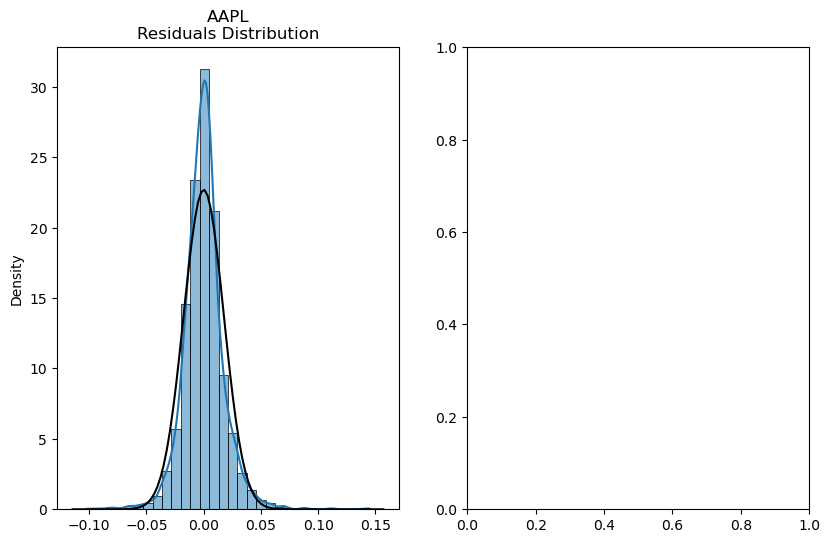

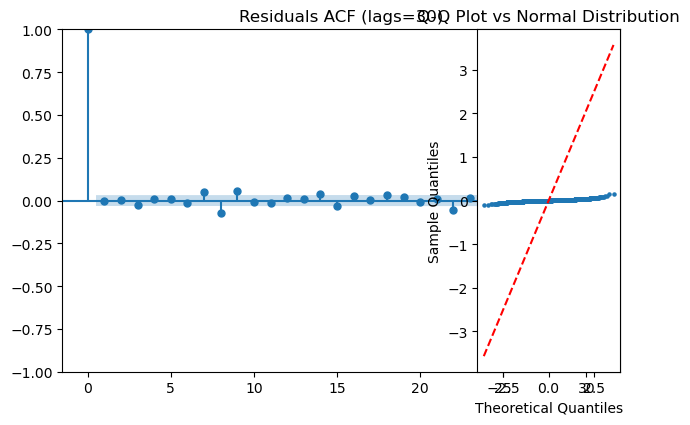


📊 AAPL - Residual Analysis:
Ljung-Box p-value (lag 30): 0.0000
Shapiro-Wilk p-value: 0.0000
Residual Stats:
Mean: 0.0000
Std Dev: 0.0176
Skewness: 0.4479
Kurtosis: 5.6824
--------------------------------------------------


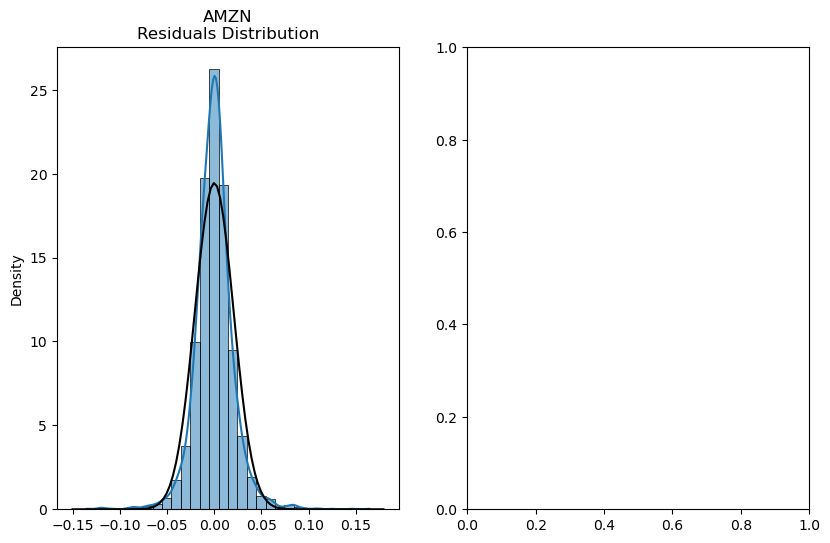

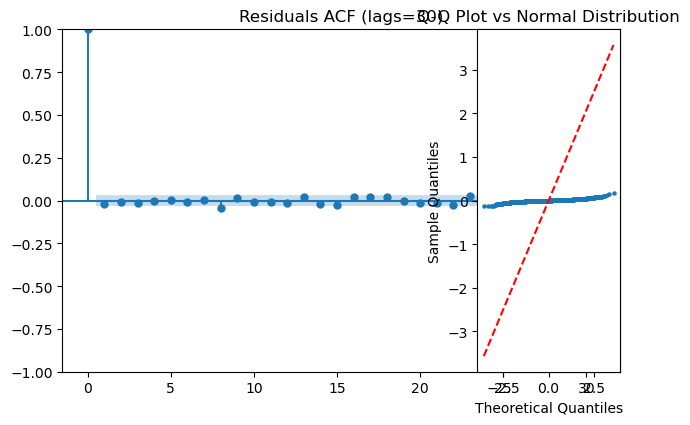


📊 AMZN - Residual Analysis:
Ljung-Box p-value (lag 30): 0.1723
Shapiro-Wilk p-value: 0.0000
Residual Stats:
Mean: 0.0000
Std Dev: 0.0205
Skewness: 0.2333
Kurtosis: 6.0473
--------------------------------------------------


In [33]:
def analyze_residuals(models_dict: dict, x: int = 10, figsize: tuple = (15, 6), 
                     bins: int = 30, lags: int = 30, alpha: float = 0.05):
    """
    Analyze residuals for the first 'x' ARIMA models with enhanced diagnostics.
    
    Parameters:
    - models_dict: Dictionary of ARIMA models {title: model}
    - x: Number of models to analyze (first x entries)
    - figsize: Figure size for plots
    - bins: Number of bins for histograms
    - lags: Number of lags for ACF and Ljung-Box test
    - alpha: Significance level for statistical tests
    """
    
    for title, model in itertools.islice(models_dict.items(), x):
        try:
            residuals = model.resid()
            
            if len(residuals) == 0:
                print(f"No residuals available for {title}")
                continue

            plt.figure(figsize=figsize)
            
            # Enhanced Histogram with PDF comparison
            plt.subplot(1, 3, 1)
            sns.histplot(residuals, bins=bins, kde=True, stat='density', 
                        edgecolor='black', linewidth=0.5)
            xmin, xmax = plt.xlim()
            x_pdf = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x_pdf, np.mean(residuals), np.std(residuals))
            plt.plot(x_pdf, p, 'k', linewidth=1.5)
            plt.title(f"{title}\nResiduals Distribution")
            
            # ACF Plot with enhanced parameters
            plt.subplot(1, 3, 2)
            plot_acf(residuals, lags=lags, alpha=alpha, 
                    title=f"Residuals ACF (lags={lags})")
            
            # Q-Q Plot for normality check
            plt.subplot(1, 3, 3)
            (osm, osr), _ = probplot(residuals, dist='norm', fit=True)
            plt.scatter(osm, osr, s=5)
            plt.plot(osm, osm, color='red', linestyle='--')
            plt.title("Q-Q Plot vs Normal Distribution")
            plt.xlabel("Theoretical Quantiles")
            plt.ylabel("Sample Quantiles")
            
            plt.tight_layout()
            plt.show()

            # Statistical tests
            print(f"\n📊 {title} - Residual Analysis:")
            
            # 1. Ljung-Box Test for autocorrelation
            lb_test = acorr_ljungbox(residuals, lags=[lags])
            print(f"Ljung-Box p-value (lag {lags}): {lb_test.iloc[-1, -1]:.4f}")
            
            # 2. Shapiro-Wilk test for normality
            shapiro_test = shapiro(residuals)
            print(f"Shapiro-Wilk p-value: {shapiro_test[1]:.4f}")
            
            # 3. Residual summary statistics
            print(f"Residual Stats:\nMean: {np.mean(residuals):.4f}")
            print(f"Std Dev: {np.std(residuals):.4f}")
            print(f"Skewness: {residuals.skew():.4f}")
            print(f"Kurtosis: {residuals.kurtosis():.4f}")
            print("-"*50)

        except Exception as e:
            print(f"Error analyzing {title}: {str(e)}")
            plt.close()

# Example usage
analyze_residuals(best_arima_models, x=2, lags=30)

c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

📊 AAPL - MAE: 0.0135


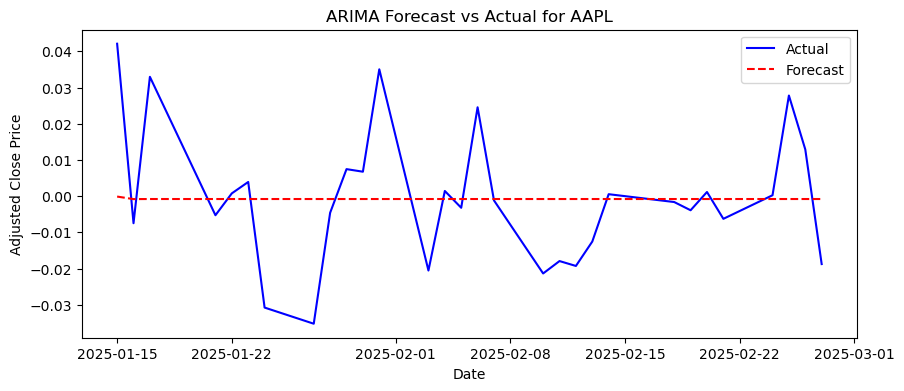

c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\carlf\anaconda3\envs\deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given wit

📊 GOOGL - MAE: 0.0158


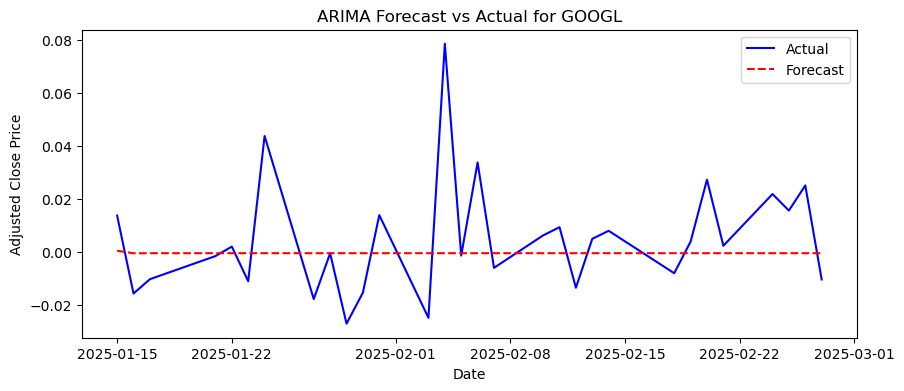

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

def forecast_with_best_models(models_dict: dict, df: pd.DataFrame, titles: list or str, 
                             test_size: int = 30, figsize: tuple = (10, 4)):
    """
    Forecast using the best ARIMA models for specified titles and evaluate performance.
    
    Parameters:
    - models_dict: Dictionary of ARIMA models {title: model}
    - df: DataFrame containing the time series data
    - titles: Single title (str) or list of titles to forecast
    - test_size: Number of observations to use as test set
    - figsize: Figure size for plots
    """
    # Convert single title to list for uniform processing
    if isinstance(titles, str):
        titles = [titles]
    
    for title in titles:
        if title not in models_dict:
            print(f"⚠️ Model for {title} not found in the dictionary. Skipping...")
            continue
        
        # Extract the series for the title
        series = df[df['Title'] == title].set_index('Date')['Adj_close']
        
        # Split into train and test sets
        train = series.iloc[:-test_size]
        test = series.iloc[-test_size:]
        
        # Get the best model order from the dictionary
        best_model = models_dict[title]
        order = best_model.order
        
        # Fit the final ARIMA model on the training data
        final_model = sm.tsa.ARIMA(train, order=order).fit()
        
        # Forecast the test set
        forecast = final_model.forecast(steps=len(test))
        
        # Evaluate with Mean Absolute Error (MAE)
        mae = mean_absolute_error(test, forecast)
        print(f"📊 {title} - MAE: {mae:.4f}")
        
        # Plot actual vs forecasted values
        plt.figure(figsize=figsize)
        plt.plot(test.index, test, label="Actual", color="blue")
        plt.plot(test.index, forecast, label="Forecast", color="red", linestyle="dashed")
        plt.legend()
        plt.title(f"ARIMA Forecast vs Actual for {title}")
        plt.xlabel("Date")
        plt.ylabel("Adjusted Close Price")
        plt.show()

# Example usage
forecast_with_best_models(best_arima_models, df, titles=["AAPL", "GOOGL"], test_size=30)